# Data Collection
First, collecting data from https://en.wikipedia.org/wiki/List_of_active_nationalist_parties_in_Europe and parse the table.

In [347]:
import json
import requests
import wikipedia

def get_wiki_page (title, country):
    wiki_endpoint = 'https://en.wikipedia.org/w/api.php'
    payload = {
        'action': 'query',
        'format': 'json',
        'titles': title,
        'prop': 'revisions',
        'rvprop': 'content',
        'utf8': 'true'
    }
    request = requests.get(wiki_endpoint, params = payload)
    print 'GET ', request.url
    data = json.loads(request.text)
    if country == 'STOP':
        return data
    try: 
        pages = data['query']['pages']
        page_id = pages.keys()[0]
        revisions = pages[page_id]['revisions'][0]['*']
        if ('#REDIRECT' in revisions):
            pattern = r'\[\[(.*?)\]\]'
            original_title =  re.findall(pattern, revisions)[0]
            print 'Redirecting to', original_title
            return get_wiki_page(original_title, country)
        try:
            wikipedia.page(title)
        except:
            augmented_title = '{} ({})'.format(title, country, title)
            return get_wiki_page(augmented_title, country)
        return data
    except KeyError:
        return data


In [19]:
# wikitables from https://github.com/bcicen/wikitables is used to 
# quickly and easily get the contents of the tables on the page

list_name = 'List of active nationalist parties in Europe'

from wikitables import import_tables
tables = import_tables(list_name)
parties = tables[0].rows
print 'Keys for every party'
for key in parties[0].keys():
    print ' - ', key
print tables[0].name 
for row in parties:
    print ' - ', row['Country'], ':', row['Party']

Keys for every party
 -  Votes
 -  % of popular vote
 -  Europarty
 -  Country
 -  Ideology, description
 -  Seats
 -  Party
 -  Date established
List of active nationalist parties in Europe[0]
 -  Armenia : Republican Party of Armenia
 -  Hungary : Fidesz
 -  Macedonia : VMRO-DPMNE
 -  Poland : Law and Justice
 -  Switzerland : Swiss People's Party
 -  Austria : Freedom Party of Austria
 -  Denmark : Danish People's Party
 -  Belgium : New Flemish Alliance
 -  Hungary : Jobbik
 -  Finland : Finns Party
 -  Italy : Lega Nord
 -  Latvia : National Alliance
 -  Norway : Progress Party
 -  Ireland : Sinn Féin
 -  France : National Front
 -  Netherlands : Party for Freedom
 -  Netherlands : Forum for Democracy
 -  Sweden : Sweden Democrats
 -  Germany : Alternative for Germany
 -  Russia : LDPR
 -  Norway : Centre Party
 -  Slovakia : Slovak National Party
 -  Estonia : Conservative People's Party of Estonia
 -  Serbia : Serbian Radical Party
 -  Slovakia : Kotleba - People’s Party Our Slo

Now that we have the contents of the table containing all the listed parties and some basic stats about them (country, number of votes etc.), we can go into the page for every party and fetch the contents. From this we'll try to parse out any non-trivial links (navigation and headers and so on) and try to build a network out of these.

In [361]:
import re

blacklist = [
    'Category',
    'list',
    'file:',
    'wiktionary:',
    'national conservatism', 
    'european parliament election',
    'right-wing populism', 
    'far-right politics', 
    'european parliament',
    'social conservatism',
    'Right-wing populism', 
    'Far-right politics', 
#     'Euroscepticism', 
    'European Union', 
    'far-right',
    'right-wing',
    'Right-wing politics', 
    'political party'
]

def processLink(link):
    decoded = link.encode('utf-8')
    split = re.split(r'[(|]+', decoded)
    return split[0]

def checkLink(link):
    return any(substring.lower() in link.lower() for substring in blacklist)

def getWikiLinks(text):
    pattern = r'\[\[(.*?)\]\]'
    links = re.findall(pattern, text)
    processed = [processLink(link) for link in links]
    return [link for link in processed if not checkLink(link)]

def clean_name(name):
    for ch in [' ', '-']:
        name = name.replace(ch, '_')
    for ch in [",", ".",'–']:
        name = name.replace(ch, '')
    return name.lower().decode('utf-8').encode('ascii', 'replace')

for i, party in enumerate(parties):
    party = dict(party)
    party_name = str(party['Party'])
    if '–' in party_name:
        party_name = party_name.split('–')[0]
    country = str(party['Country'])
    party_title = clean_name(party_name)
    party['title'] = party_title
    print 'Party name:', party_name, country
    pages_json = get_wiki_page(party_name, country)
    pages = pages_json['query']['pages']
    for key in pages.keys():
        try:
            text = pages[key]['revisions'][0]['*']
            party['links'] = list(set(getWikiLinks(text)))
            print 'Found', len(party['links']), 'links\n'
            if len(party['links']) < 20:
                print json.dumps(pages_json, indent=2)

        except:
            try:
                pages_json = get_wiki_page(party_name, 'political party')
                pages = pages_json['query']['pages']
                for key in pages.keys():
                    text = pages[key]['revisions'][0]['*']
                    party['links'] = list(set(getWikiLinks(text)))
                    print 'Found', len(party['links']), 'links\n'
            except:
                print '--------- Failed to fetch text for', party_name, '\n'
                party['links'] = []
                continue
    parties[i] = party    


Party name: Republican Party of Armenia Armenia
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Republican+Party+of+Armenia&action=query
Found 56 links

Party name: Fidesz Hungary
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Fidesz&action=query
Found 84 links

Party name: VMRO-DPMNE Macedonia
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=VMRO-DPMNE&action=query
Found 67 links

Party name: Law and Justice Poland
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Law+and+Justice&action=query
Found 138 links

Party name: Swiss People's Party Switzerland
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Swiss+People%27s+Party&action=query
Found 129 links

Party name: Freedom Party of Austria Austria
GET  https://en.wikipedia.org/w/api.php?

GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Svoboda&action=query
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Svoboda+%28political+party%29&action=query
Found 316 links

Party name: Attack Bulgaria
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Attack&action=query
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Attack+%28Bulgaria%29&action=query
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Attack&action=query
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Attack+%28political+party%29&action=query
Found 104 links

Party name: Brothers of Italy  Italy
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Brothers+of+Italy+&action=q

GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Greater+Romania+Party&action=query
Found 66 links

Party name: Workers' Party Czech Republic
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Workers%27+Party&action=query
Found 112 links

Party name: Lithuanian Nationalist Union Lithuania
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Lithuanian+Nationalist+Union&action=query
Found 31 links

Party name: Young Lithuania Lithuania
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Young+Lithuania&action=query
Found 7 links

{
  "batchcomplete": "", 
  "query": {
    "pages": {
      "35797496": {
        "ns": 0, 
        "pageid": 35797496, 
        "revisions": [
          {
            "*": "{{Refimprove|date=May 2012}}\n{{Infobox political party\n| country       = Lithuania\n| name  = You

GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Albanian+National+Front+Party&action=query
Found 33 links

Party name: New Force Italy
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=New+Force&action=query
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=New+Force+%28Italy%29&action=query
Found 64 links

Party name: Estonian Independence Party Estonia
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Estonian+Independence+Party&action=query
Found 20 links

Party name: Bulgarian National Union  Bulgaria
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Bulgarian+National+Union+&action=query
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Bulgarian+National+Union+&action=query
--------- Faile

GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=National+Movement&action=query
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=National+Movement+%28Poland%29&action=query
Found 49 links

Party name: Belarusian Popular Front Belarus
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Belarusian+Popular+Front&action=query
Found 64 links



With all data collected as a list of parties with the links from their pages stored within, two networks are constructed. One that where edges are created when a party's page's links contain another party directly (first order), and one where the edges consist of two party's that have a common link (second order). The latter will have the link stored on the edge attribute.

In [362]:
import networkx as nx

# initialize multiple graphs
graph_first = nx.Graph()
graph_scnd = nx.Graph()


for party in parties:
    # add nodes to both graphs
    graph_first.add_node(party['title'], **dict(party))
    graph_scnd.add_node(party['title'], **dict(party))

    
for i, party in enumerate(parties):
    links = party['links']
    for link in links:
        clean_link = clean_name(link)
        # add an edge if a page of one party mentions another to 'first'
        if graph_first.has_node(clean_link):
            graph_first.add_edge(clean_link, party['title'])
        for j, party2 in enumerate(parties):
            # add an edge if two party's pages have a link in commonn to 'second'
            if i != j:
                links2 = party2['links']
                for link2 in links2:
                    if link == link2 and not graph_scnd.has_edge(party2['title'], party['title']):
                        graph_scnd.add_edge(party2['title'], party['title'], link=clean_link)

Some very basic visualization of these graphs.

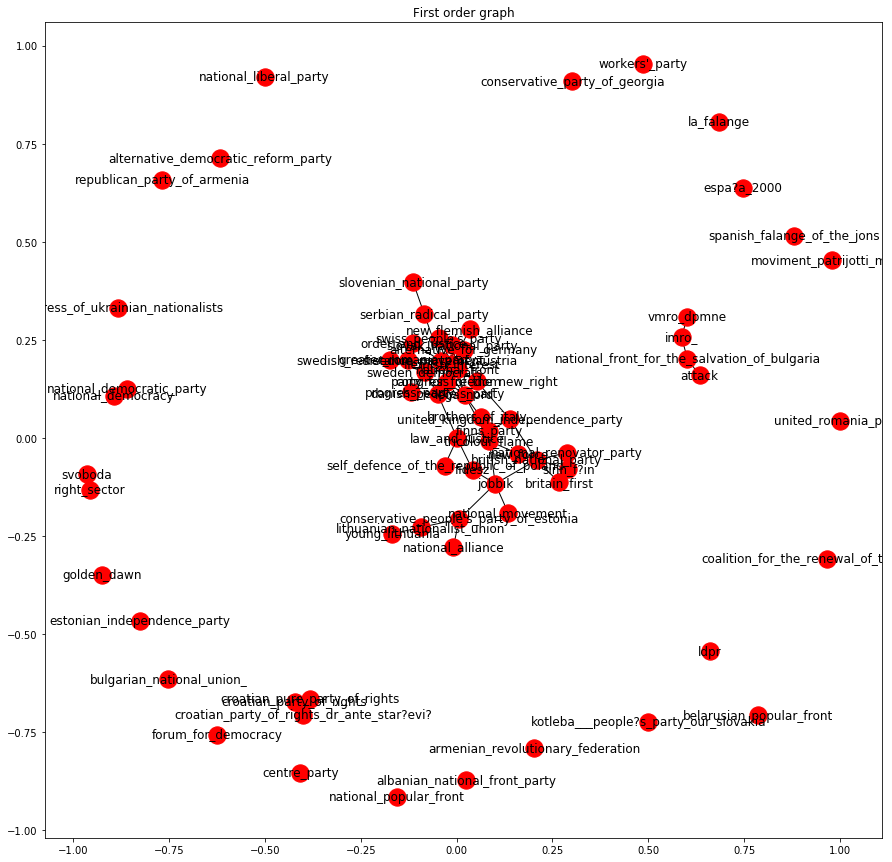

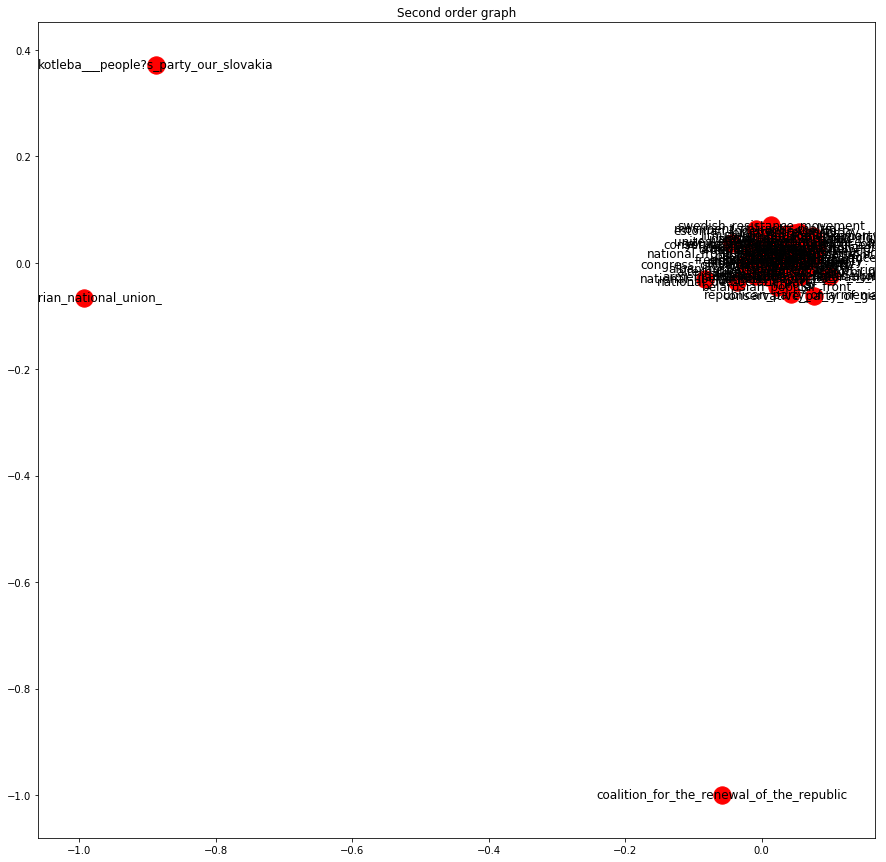

In [363]:
import matplotlib.pyplot as plt
%matplotlib inline

# try:
#     import pygraphviz
#     from networkx.drawing.nx_agraph import graphviz_layout
#     layout = graphviz_layout
# except ImportError:
#     print 'No graphviz'
#     try:
#         import pydot
#         from networkx.drawing.nx_pydot import graphviz_layout
#         layout = graphviz_layout
#     except ImportError:
#         print("PyGraphviz and pydot not found;\n"
#               "drawing with spring layout;\n"
#               "will be slow.")
layout = nx.spring_layout

figure = plt.figure(figsize=(15, 15))
plt.title('First order graph')
pos = layout(graph_first)
nx.draw_networkx(graph_first, pos, with_labels=True)

figure = plt.figure(figsize=(15, 15))
pos = layout(graph_scnd)
plt.title('Second order graph')
nx.draw_networkx(graph_scnd, pos, with_labels=True)





# Basic Stats
We'll have a look at some basic stats for the graphs, like their size in terms of nodes and edges, the size of the GCC and the degree distribution.

Graph 1
Number of nodes: 70
Number of edges: 66
The average degree of the network is 1.8857142857142857
The median degree of the network is 1.0
Number of nodes in GCC: 36
Graph 2
Number of nodes: 70
Number of edges: 1355
The average degree of the network is 38.714285714285715
The median degree of the network is 43.5
Number of nodes in GCC: 67


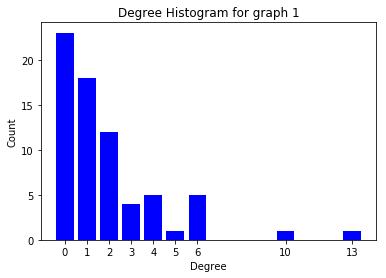

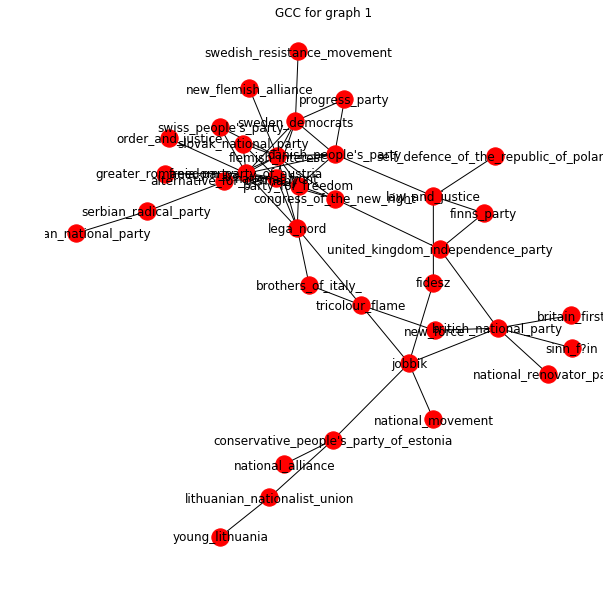

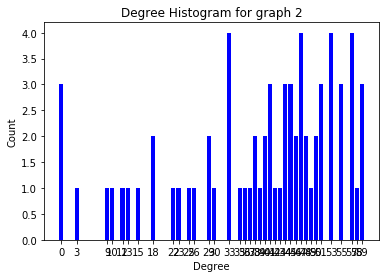

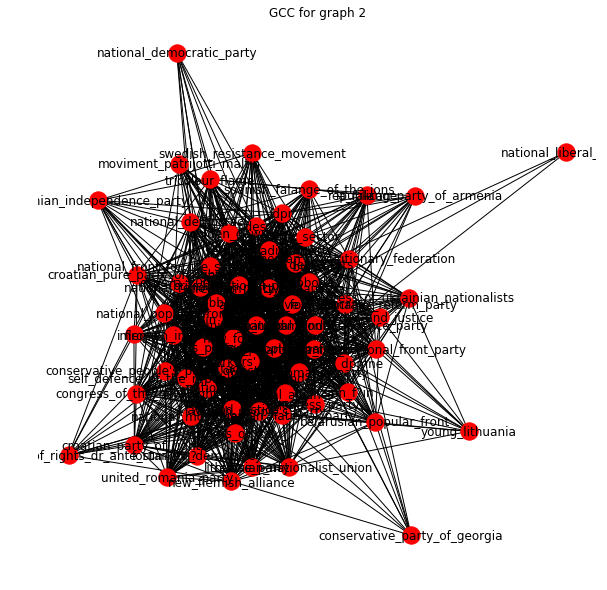

In [364]:
import numpy as np
from collections import Counter

for i, graph in enumerate([graph_first, graph_scnd]):
    print 'Graph', i + 1
    print 'Number of nodes:', len(graph.nodes)
    print 'Number of edges:', len(graph.edges)
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)  # degree sequence
    degreeCount = Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())    
    
    print 'The average degree of the network is', np.average(degree_sequence)
    print 'The median degree of the network is', np.median(degree_sequence)
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram for graph {}".format(i + 1))
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d for d in deg])
    ax.set_xticklabels(deg)
    Gcc = sorted(nx.connected_component_subgraphs(graph), key=len, reverse=True)
    G0 = Gcc[0]
    print 'Number of nodes in GCC:', len(G0.nodes)
    fig = plt.figure(figsize=(10, 10))
    plt.title('GCC for graph {}'.format(i + 1))
    pos = layout(G0)
    nx.draw(G0, pos, with_labels=True)


(u'euroscepticism', u'ultranationalism', u'red', u'nationalism', u'nato', u'economic_nationalism')


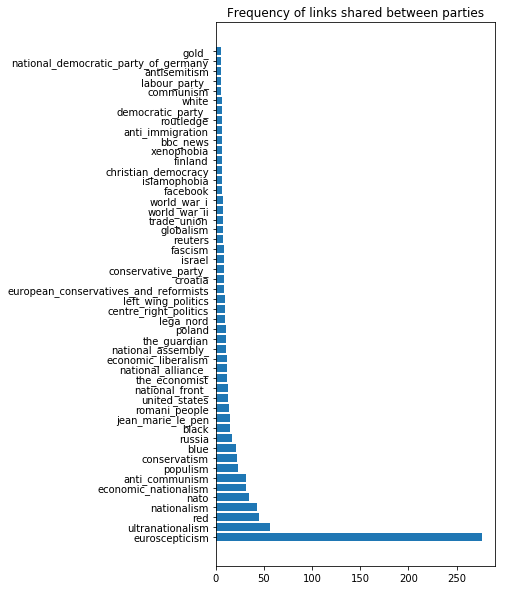

In [365]:
# linklist = map(lambda p: p['links'], parties)
# links = [link for links in linklist for link in links]

links  = sorted(nx.get_edge_attributes(graph_scnd, 'link').values())
links = [link.decode('utf-8') for link in links]
link_counts = Counter(links)


lnk, cnt = zip(*link_counts.most_common(50)) 
print lnk[0:6]
fig = plt.figure(figsize=(5, 10))

plt.barh(range(len(lnk)),cnt)
plt.yticks(range(len(lnk)),lnk)
plt.title('Frequency of links shared between parties')
plt.show()


# Color Coded Vizualization
A distinct set of colors is used for every country to color the parties taken from http://phrogz.net/css/distinct-colors.html.

['#e53d00', '#e57373', '#000033', '#0066bf', '#005266', '#bffbff', '#cf73e6', '#c200f2', '#e57373', '#5c7300', '#eeb6f2', '#e57373', '#2db386', '#2db386', '#ffd580', '#1a2e66', '#e6f23d', '#9cbf8f', '#602080', '#bffbff', '#001bcc', '#a66c29', '#8c3f23', '#2db386', '#e57373', '#739996', '#2d594a', '#8c3f23', '#eeb6f2', '#ffaa00', '#005924', '#2db386', '#8c3f23', '#cf73e6', '#cf73e6', '#9cbf8f']
[France, Italy, Estonia, Switzerland, Latvia, Sweden, United Kingdom, Austria, Italy, Germany, Hungary, Italy, Poland, Poland, Ireland, Romania, Slovenia, Belgium, Serbia, Sweden, Portugal, Slovakia, Lithuania, Poland, Italy, Finland, Denmark, Lithuania, Hungary, Norway, Netherlands, Poland, Lithuania, United Kingdom, United Kingdom, Belgium]


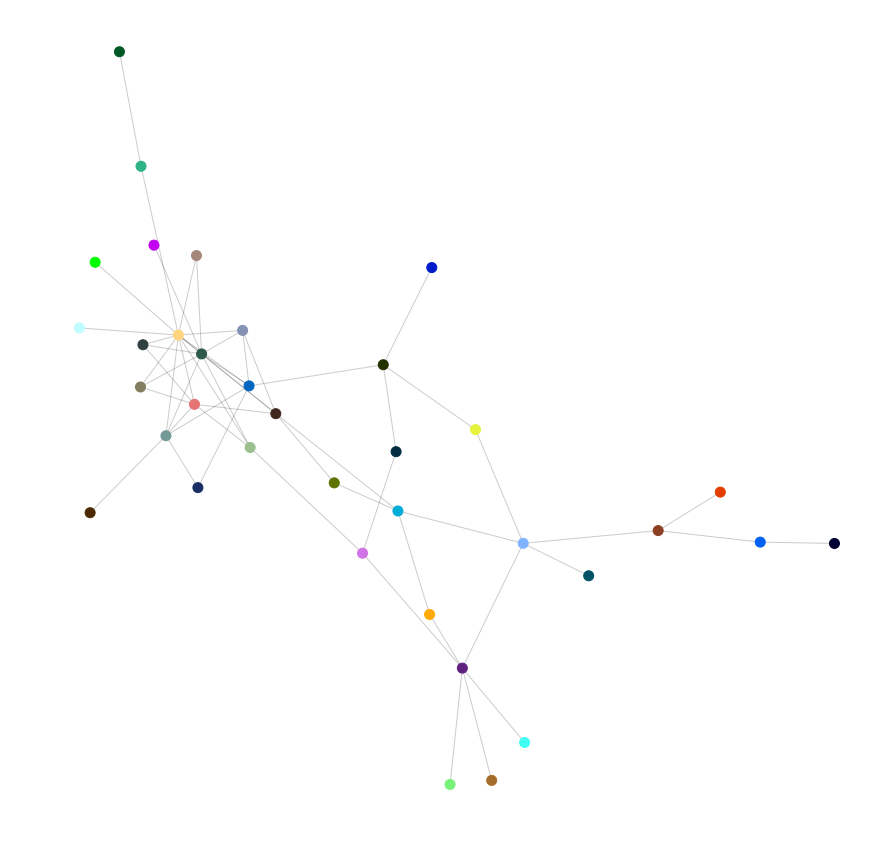

In [457]:
countries = set([str(d['Country']) for d in parties])
with open('data/colors.txt') as infile:
    colors = [s.strip() for s in infile.read().split(',')]

color_country = dict(zip(countries, colors))
def draw_color_net (graph):
    nodes = graph.nodes()

    node_colors = [color_country[str(graph.node[n]['Country'])] for n in nodes]
    print node_colors
    print [graph.node[n]['Country'] for n in nodes]
    fig = plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(graph)
    ec = nx.draw_networkx_edges(graph, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(graph, pos, nodelist=nodes, node_color=colors, with_labels=True,
                                node_size=100, cmap=plt.cm.jet)
#     plt.colorbar(nc)
    plt.axis('off')
    plt.show()
    
Gcc_first = sorted(nx.connected_component_subgraphs(graph_first), key=len, reverse=True)
G0_first = Gcc_first[0]

draw_color_net(G0_first)

# Fascist Movements
Next, data is collected from https://en.wikipedia.org/wiki/List_of_fascist_movements_by_country to complement the previous graphs. Only european movements are kept in, but for now we'll look at both acitve and inactive movements.

In [450]:
from bs4 import BeautifulSoup

# the pages are divided up per country according these lettergroups
divisions = ['A–F', 'G–M', 'N–T', 'U–Z']

# main article
fascist_list = 'List of fascist movements by country'

# loop over 4 pages
for div in divisions:
    # get & parse HTML
    wiki = wikipedia.page('{} {}'.format(fascist_list, div))
    soup = BeautifulSoup(wiki.html(), 'html.parser')
    table = soup.find('table')
    
    # collect entries in table
    movements = []
    for i, row in enumerate(table.findAll("tr")):
        # first row are headers, save as keys
        if i == 0:
            keys = [ele.text.strip() for ele in row.findAll('b')]
            keys.append('link')
        
        # parse out text of the cells and save the href
        else: 
            cells = [ele.text.strip() for ele in row.findAll("td")]
            link = row.find('a')
            if link:
                link = link.get('href')
            movement = dict(zip(keys, cells + [link]))
            movements.append(movement)
            
print 'Found', len(movements), 'movements'

Found 74 movements


In [462]:
# filter european movements
movements = filter(lambda m: any(c.lower() in m['Country of predominant operation'].lower() for c in countries), movements)
print 'There are', len(movements), 'movements in europe'

# fetch pages and parse links
for i, mov in enumerate(movements):
    try:
        page = wikipedia.page(mov['Name of movement'])
        if page and mov['link']:
            mov['links'] = page.links
            print 'Found {} links for {}'.format(len(page.links), mov['Name of movement'])
    except:
        print 'Failed to collect for {}'.format(mov['Name of movement'])
        mov['links'] = []
        continue
    movements[i] = mov


There are 38 movements in europe
Found 434 links for Blood and Honour
Found 485 links for Britain First
Found 338 links for British Democratic Party
Found 592 links for British Fascisti
Found 392 links for British Movement
Found 534 links for British National Front
Found 237 links for British National Party (1960s)
Found 744 links for British National Party
Found 535 links for British Nazi Party
Found 239 links for British People's Party (2005)
Found 611 links for British People's Party (1939)
Found 673 links for British Union of Fascists
Found 479 links for Combat 18
Found 225 links for Constitutional Movement
Found 229 links for England First Party
Found 226 links for Flag Group
Found 227 links for Greater Britain Movement
Found 542 links for Imperial Fascist League
Found 241 links for League of St. George
Found 253 links for National Democrats (UK)
Found 537 links for National Fascisti
Found 234 links for National Labour Party (UK 1950s)
Found 226 links for National Party (UK, 1976)

In [443]:
print movements[0]

{u'Active?': u'Yes', u'Name of movement': u"[SPAS] (Sotsial-Patriotichna Asambleya Slov'yan, \u0421\u041f\u0410\u0421, \u0421\u043e\u0446\u0456\u0430\u043b-\u041f\u0430\u0442\u0440\u0456\u043e\u0442\u0438\u0447\u043d\u0430 \u0410\u0441\u0430\u043c\u0431\u043b\u0435\u044f \u0421\u043b\u043e\u0432'\u044f\u043d)", u'General affiliation': u'Ukrainian Nationalism', u'Notes': u'Ukrainian', u'Country of predominant operation': u'Ukraine', u'Came to power?': u'No', u'Founded post-World War II?': u'Yes', 'link': None}
